Getting rid of Noise


68,2% Werte sammeln für mehrere IDs

Daraus dann Verteilung - Histogram - Gauß Fitt?

Ist globaler wert repräsentativ?

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import csv 
import numpy as np
import scipy.optimize as opt
import array

In [8]:

def create_dataframe(file_path):
    """
    Reads in a csv file and creates a header and a data section

    Args:
        file_path (str): a relative or abolute pathway to the file, which contains the whole information

    Returns:
        header_section (list): list with each line of the header as an entry
        data_section_raw (dataframe): pandas dataframe of the data section

    """

    with open(file_path, 'r') as csv_file:
        data = csv.reader(csv_file, delimiter=';')

        header_section = []
        column_names = ["ID","Frame index","Groups","Donor Photons","Acceptor Photons","FRET efficiency","X (nm)","Y (nm)"]
        #nicht so sauber
        data_section_raw = pd.DataFrame(columns = column_names)

        #for row in data:
            #print(row)

        for n, row in enumerate(data):
            if n < 15:
            #das mit 15 ist unsauber
                header_section.append(row)
            elif n == 15:
                continue
            elif row == ['', '', '', '', '', '', '', '']:
                continue
            else:
                new_row=[]
                for element in row:
                        try:
                            new_row.append(float(element))
                        except ValueError:
                            new_row.append(0)

                data_section_raw.loc[n]=new_row

    return header_section, data_section_raw


In [9]:
def haar_cyles (dataframe, number_cycles):

    # FRET Werte aus Dataframe in eine lange Liste geben 

    FRET_list = []
    for element in dataframe["FRET efficiency"]:
        FRET_list.append(element)

    # Je ein Dict erstellen - Mit je zwei Werten und Mittelwert - 1 lange liste mit Dicts
        # Wenn einer der Werte 0 - überspringen
        # Wenn einer der Werte aus neuer ID - überspringen (noch nicht implementiert)

    new_list = []

    for number, element in enumerate(FRET_list):
        if number % 2 == 0:
            continue
        
        new_dict = {"First": FRET_list[number-1] ,"Second": FRET_list[number], "Mean": (FRET_list[number]+FRET_list[number-1])/2}
        
        if new_dict["First"] != 0 and new_dict["Second"] != 0:
            new_list.append(new_dict)

    #print(new_list)

    # Pro Zyklus: (0 Zyklen = überspringen)
        # Von zwei Dicts hintereinander die Mittelwerte als Werte für neues Dict
        # Mittelwert dieser berechnen und ebenfalls in Dict
        # Belieblig oft wiederholen

    while number_cycles > 0:

        iter_list = new_list.copy()
        new_list = []

        #print("____________________________________________")
        #print("One cycle happend")
        #print("____________________________________________")

        for number, element in enumerate(iter_list):

            try:

                if number % 2 == 0:
                    continue
        
                new_dict = {"First": iter_list[number-1]["Mean"] ,"Second": iter_list[number]["Mean"], "Mean": (iter_list[number]["Mean"]+iter_list[number-1]["Mean"])/2}
                new_list.append(new_dict)
                
            except IndexError:
                continue

        number_cycles = number_cycles - 1

        #print (new_list)

    # Abweichung von Werten zu  Mittelwert berechnen
    # Diese Abweichung in Liste geben

    noises = []

    for element in new_list:
        noise = element["Mean"] - element["First"]
        noises.append(abs(noise))
        #noises.append(noise)

    # print("\n-------------------------------\n")
    # print("List of noises")
    # print(noises)

    return noises

In [10]:
def histogram_fit (noises, binsize, cutoff = 68.2):

    y_values, bin_edges, third_variable = plt.hist(noises, binsize)
    
    bin_edges_list = []

    for element in bin_edges:
        bin_edges_list.append(element)


    bin_width = (bin_edges_list[1] - bin_edges_list [0])

    x_values = []

    for element in bin_edges_list:
        current_value = element + bin_width/2
        x_values.append(current_value)

    x_values.pop()
    # Letzter Wert muss weg weil letzte Bin-Grenze + 1/2 Binsize keinem Datenpunkt entspricht!

    plt.scatter(x_values, y_values, c = "red")
    #plt.figure(figsize=(50, 100), dpi = 80)
    plt.rcParams['figure.figsize'] = [10, 12]
    plt.show

    y_values_cumu = []
    current_value = 0

    for element in y_values:
        current_value += element
        y_values_cumu.append(current_value)

    #print(y_values_cumu)

    plt.scatter(x_values, y_values_cumu, c = "green")
    plt.show

    hundred_percent = y_values_cumu[-1]
    value_crit = hundred_percent * cutoff/100

    print(f"The value at {cutoff}% is {value_crit}")

    plt.axhline(y=value_crit, color="yellow", linestyle='-')
    plt.show

    y_values_cumu = array.array("f", y_values_cumu)
    #?????????????????????????????????????????

    return y_values, y_values_cumu, x_values, value_crit



In [11]:
def gaussian_curve_fit (x_values, y_values):

    # das unterhalb funktioniert nur wenn die y-werte arrays sind!
    # y values ist array, aber y values cumu ist liste!

    #y_values = array.array("f", y_values)

    print(y_values)
    print(type(y_values))

    random_list = [4,2,6,2,7,7,5,3,2,5,6,3]

    random_array = array.array("f", random_list)
    print(random_array)
    print(type(random_array))

    # random_numpy = np.ndarray(shape = (),dtype = float, buffer = random_list)
    # print(random_numpy)


    #Dieser Teil derzeit nur Copy Paste!

    n = len(x_values)                         
    mean = sum(x_values*y_values)/n                  
    sigma = sum(y_values*(x_values-mean)**2)/n 

    def gauss_function(x, a, x0, sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
        # a = height of the curves peak
        # x0 = position of center of peak
        # sigma = controlls the width of the "bell"
        
    popt,pcov = opt.curve_fit(f = gauss_function, xdata = x_values, ydata = y_values, p0=[1,mean,sigma])

    plt.plot(x_values,y_values,'b+:',label='data')
    plt.plot(x_values,gauss_function(x_values,*popt),'ro:',label='fit')
    plt.legend()
    plt.title('Fig. 3 - Fit for Time Constant')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.show()

The value at 68.2% is 124.806
[44. 35. 23. 26. 16. 16.  2.  6.  4.  3.  5.  1.  0.  0.  1.  0.  0.  0.
  0.  1.]
<class 'numpy.ndarray'>
array('f', [4.0, 2.0, 6.0, 2.0, 7.0, 7.0, 5.0, 3.0, 2.0, 5.0, 6.0, 3.0])
<class 'array.array'>


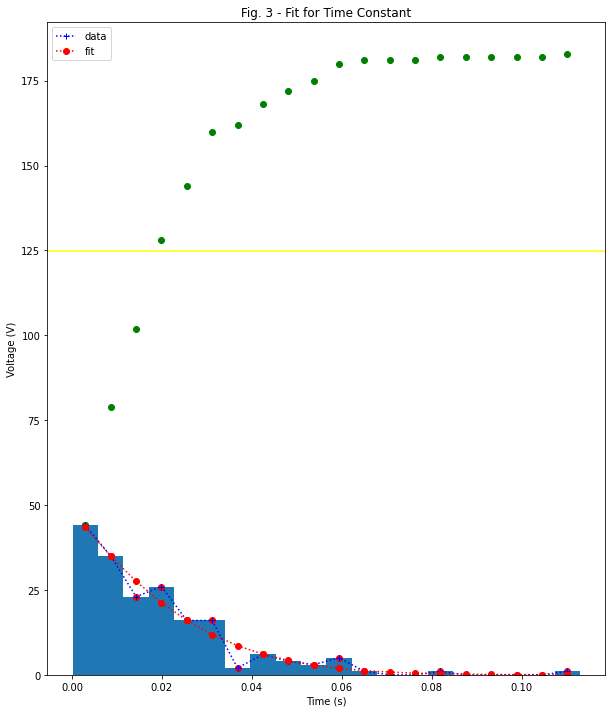

In [12]:

header, dataframe = create_dataframe("./dsDNA_PEGylatedSlides_for noise thresholding only 2 IDs.csv")
#header, dataframe = create_dataframe("./dsDNA_PEGylatedSlides_for noise thresholding.csv")

#print(dataframe)

noises = haar_cyles(dataframe,1)

y_values, y_values_cumu, x_values, value_crit = histogram_fit(noises, 20)

test = gaussian_curve_fit (x_values, y_values)
#test = gaussian_curve_fit (x_values, y_values_cumu)
